## Observations and Insights 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns
import numpy as np

In [2]:
# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
# merged_inner = pd.merge(left=survey_sub, right=species_sub, left_on='species_id', right_on='species_id')
masterDf = pd.merge(left=mouse_metadata,right=study_results, how='outer')
print(f"{masterDf.shape}")

(1893, 8)


In [3]:
#  duplicate measurements/entries
duplicateRowsDf = masterDf[masterDf[["Mouse ID","Timepoint"]].duplicated(keep='first')]
print(f"{duplicateRowsDf.shape}")

(5, 8)


In [4]:
# check if there is any missing/null value
print(f"Is there null value? {masterDf.isnull().values.any()}")

# number of unique mice
nMice = len(masterDf["Mouse ID"].unique())

# drop duplicates
masterDf = masterDf.drop_duplicates(subset=["Mouse ID", "Timepoint"], keep='first')
masterDf.head()
print(f"{masterDf.shape}")

#1893 rows - 5 duplicate rows = 1888 rows (matches!)

Is there null value? False
(1888, 8)


## Summary Statistics

In [5]:
# unique entries for gender (to make sure no typo)
gender = masterDf["Sex"].unique()

# add two columns to track Male/Female for groupby conditional count later
masterDf["Male"] = masterDf["Sex"].apply(lambda x: 1 if x == "Male" else 0)
masterDf["Female"] = masterDf["Sex"].apply(lambda x: 1 if x == "Female" else 0)

In [6]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# at each time point, get mouse and gender count to see alive mouse after each timepoint

# This method: shortesyntax but has two level of colum names, harder to access 
# summaryStatsByTimePoint = masterDf[["Drug Regimen","Timepoint","Tumor Volume (mm3)","Male","Female","Mouse ID"]]\
#                 .groupby(["Drug Regimen","Timepoint"]).agg({"Tumor Volume (mm3)":['mean','median','var','std','sem'],\
#                                                             "Mouse ID": 'nunique',"Male": 'sum', "Female": 'sum'}).reset_index("Timepoint")

# This method: can generate desired column names while excuting groupby methods
summaryStatsByTimePoint = masterDf[["Drug Regimen","Timepoint","Tumor Volume (mm3)","Male","Female","Mouse ID"]]\
                .groupby(["Drug Regimen","Timepoint"]).agg( Mean_Tumor_Volume=("Tumor Volume (mm3)","mean"),\
                                                Median_Tumor_Volume=("Tumor Volume (mm3)","median"),\
                                                Var_Tumor_Volume=("Tumor Volume (mm3)","var"),\
                                                Std_Tumor_Volume=("Tumor Volume (mm3)","std"),\
                                                Sem_Tumor_Volume=("Tumor Volume (mm3)","sem"),\
                                                Number_of_Mice=("Mouse ID", 'nunique'),\
                                                Number_of_Male =("Male",'sum'),\
                                                Number_of_Female=("Female",'sum')).reset_index("Timepoint").reset_index("Drug Regimen")


In [7]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# aggregated across all timepoints

summaryStats= masterDf[["Drug Regimen","Tumor Volume (mm3)","Mouse ID"]]\
                .groupby(["Drug Regimen"]).agg( Mean_Tumor_Volume=("Tumor Volume (mm3)","mean"),\
                                                Median_Tumor_Volume=("Tumor Volume (mm3)","median"),\
                                                Var_Tumor_Volume=("Tumor Volume (mm3)","var"),\
                                                Std_Tumor_Volume=("Tumor Volume (mm3)","std"),\
                                                Sem_Tumor_Volume=("Tumor Volume (mm3)","sem"),\
                                                Number_of_Mouse=("Mouse ID", 'nunique')).reset_index("Drug Regimen")

## Bar and Pie Charts

Text(0.5, 1, 'Total number of mice throughout treatment for each drug regimen')

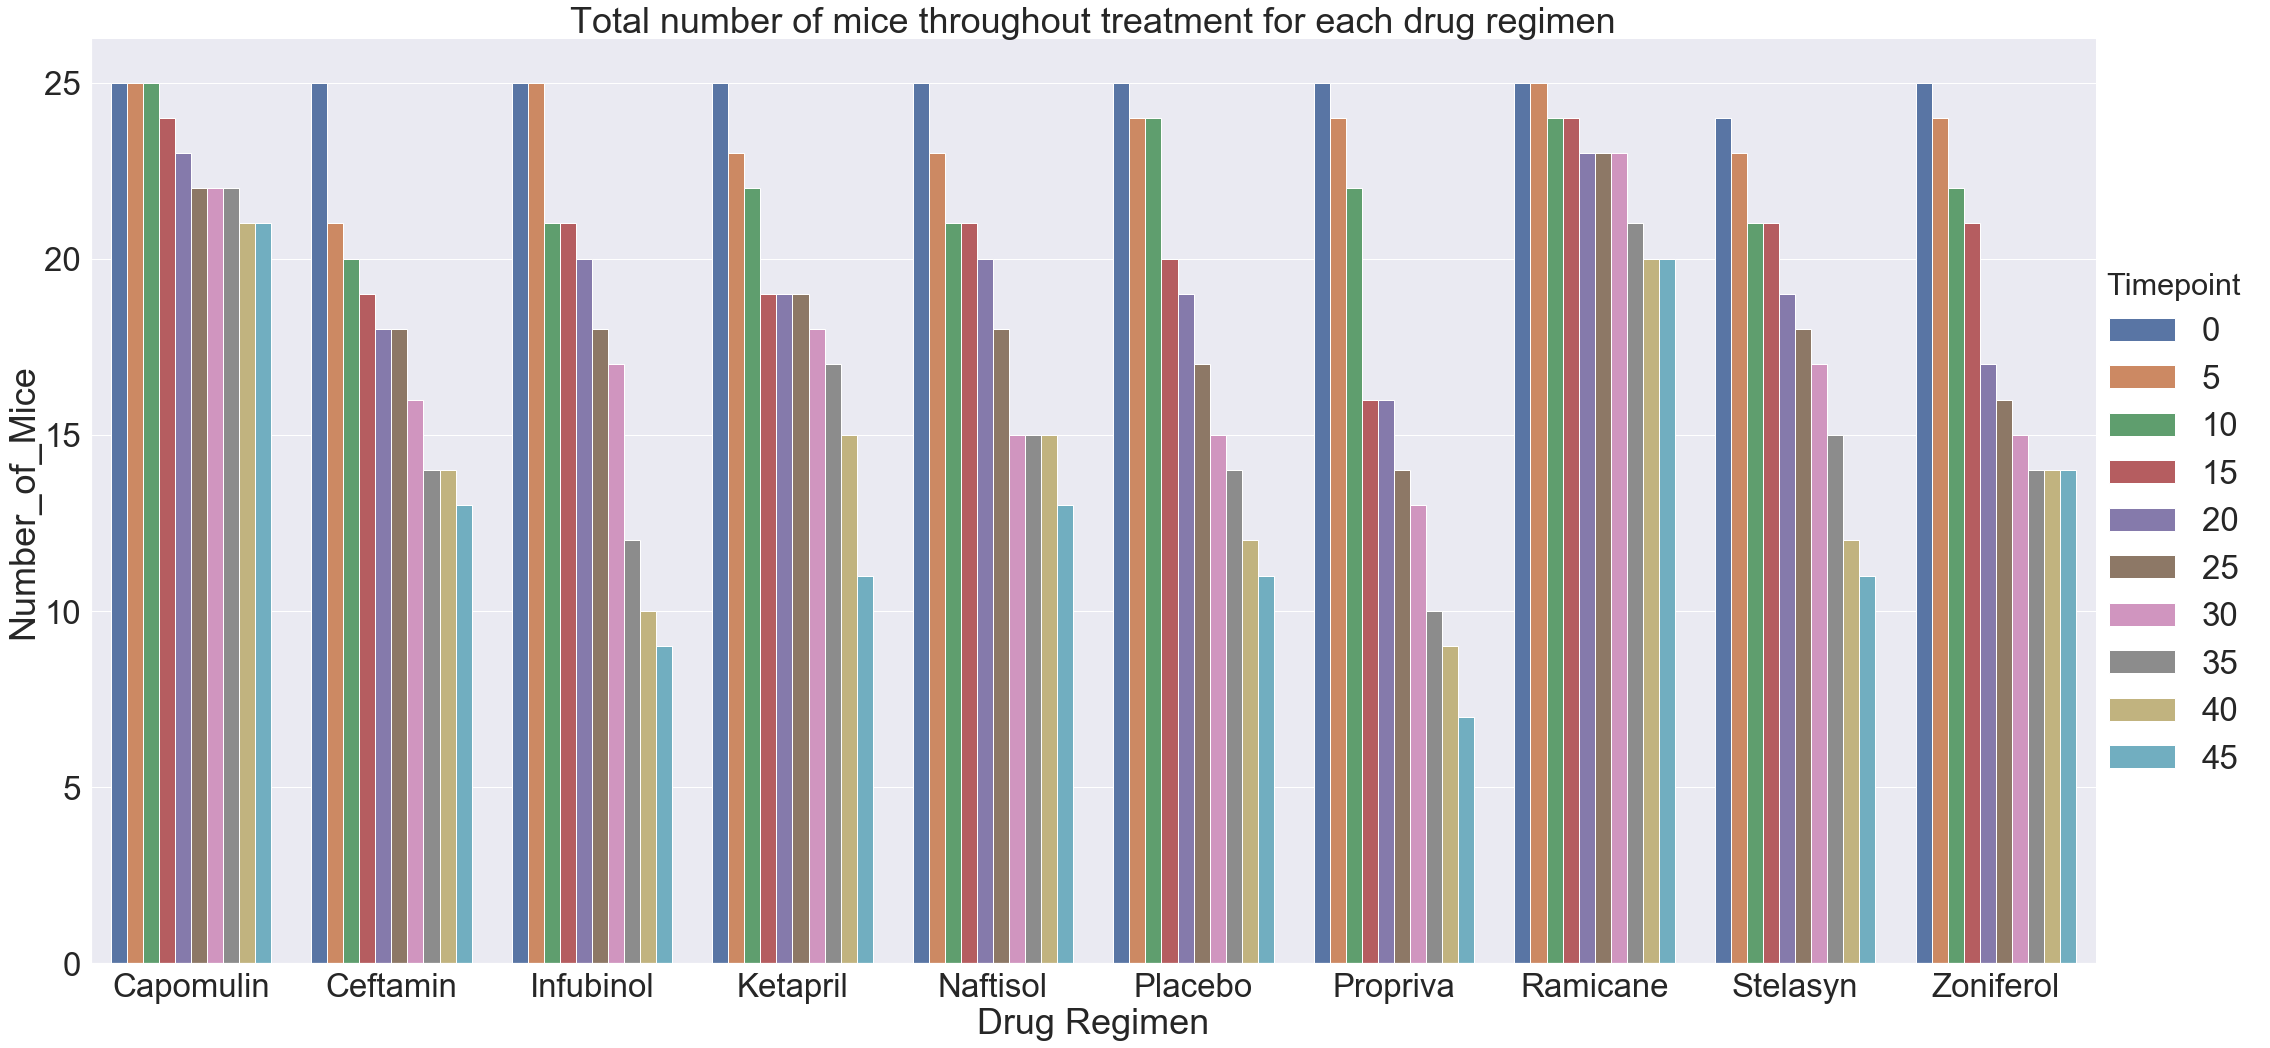

In [8]:
# Use seaborn
# Plot numbers of mice throughout the treatment for each drug regimen
sns.set(font_scale=3)
fig1 = sns.catplot(x = "Drug Regimen",       # x variable name
            y = "Number_of_Mice",       # y variable name
            data = summaryStatsByTimePoint,     # dataframe to plot
            hue = "Timepoint",
            kind = "bar",
            height=15,    
            aspect=2) 
plt.title('Total number of mice throughout treatment for each drug regimen')
#  Based on this bar plot: Capomulin and Ramicane are least lethal compared to the rest

Text(0, 0.5, 'Number of Mice')

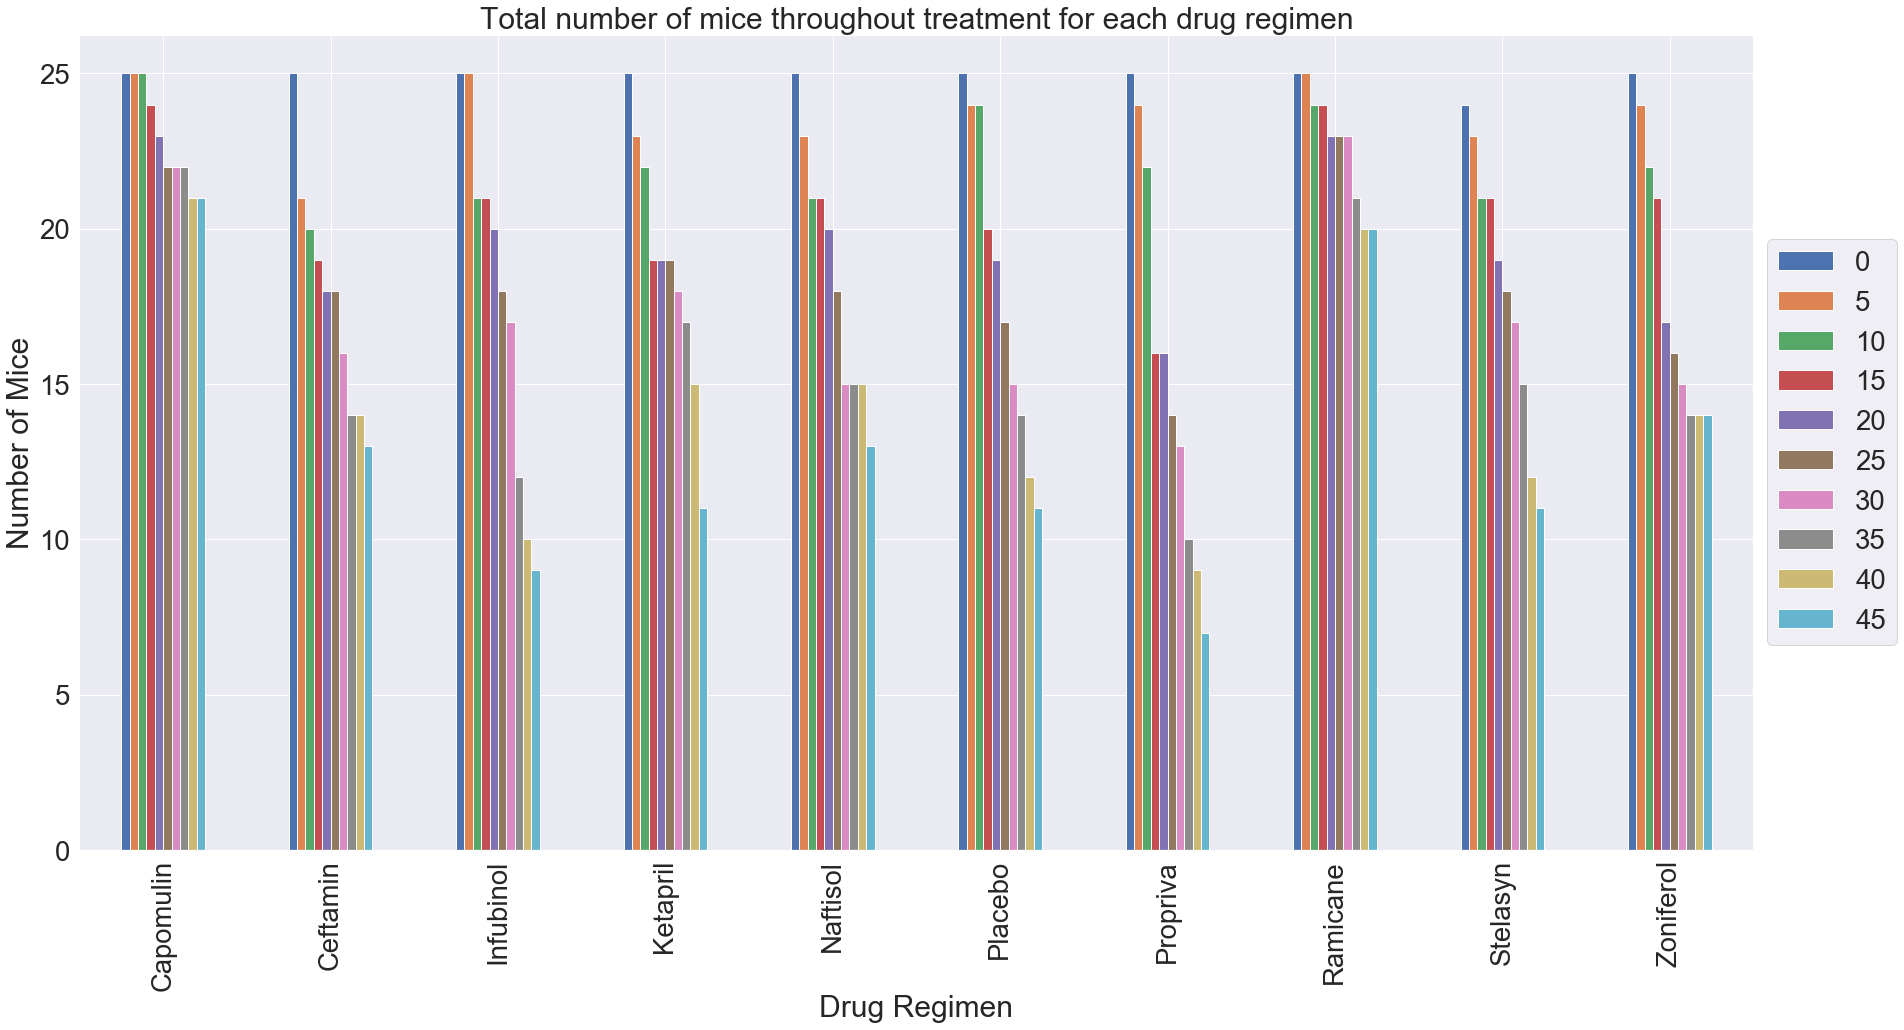

In [9]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pandas.
# Using pandas df.plot
sns.set(font_scale=2.5)
nMiceStats = masterDf[["Drug Regimen","Timepoint","Mouse ID"]].groupby(["Drug Regimen","Timepoint"])\
            .agg({"Mouse ID":"nunique"}).unstack()
nMiceStats.columns = nMiceStats.columns.droplevel()
fig1b = nMiceStats.plot(kind = 'bar',figsize=(30, 15),legend=False,title = 'Total number of mice throughout treatment for each drug regimen')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig1b.set_ylabel('Number of Mice')

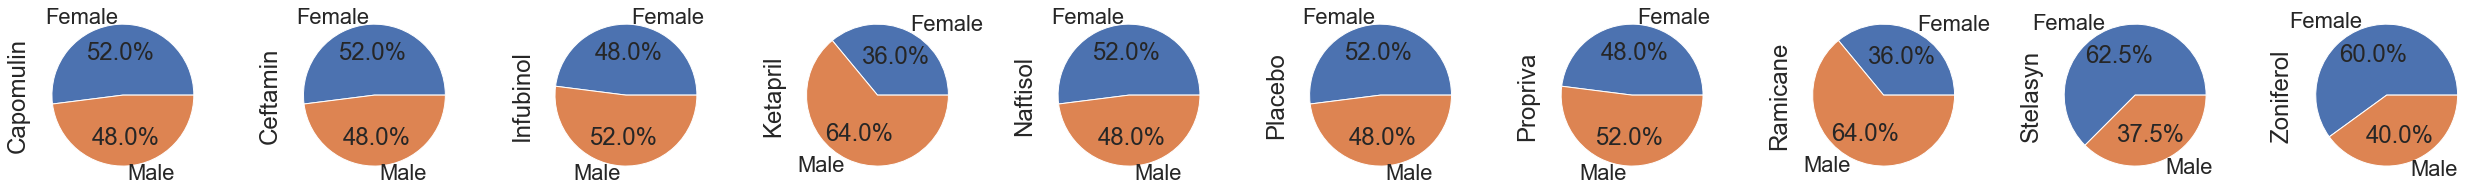

In [10]:
# pie chart for each treatment
# 10 pie total for 10 drugs
genderStatsByDrug = masterDf.loc[masterDf["Timepoint"]==0]
genderStatsByDrug = genderStatsByDrug[["Drug Regimen","Sex","Mouse ID"]].groupby(["Drug Regimen","Sex"])\
                    .agg(Number_of_Mice=("Mouse ID", 'nunique')).reset_index("Drug Regimen").reset_index("Sex")
# plot
sns.set(font_scale=2)
fig2 = genderStatsByDrug.pivot("Sex","Drug Regimen","Number_of_Mice").plot.pie(subplots=True, legend=False, autopct='%.1f%%',figsize=(35,35))
plt. tight_layout() 
plt.show()

([<matplotlib.patches.Wedge at 0x199df4ed048>,
 [Text(-0.7728952440707736, 0.7827087208488094, 'Female'),
  Text(0.8431584480772075, -0.8538640591077923, 'Male')],
 [Text(-0.4215792240386037, 0.42693202955389603, '49.8%'),
  Text(0.49184242804503764, -0.49808736781287877, '50.2%')])

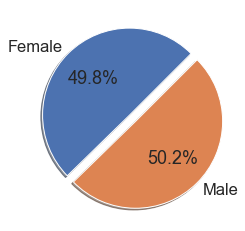

In [11]:
# Generate a pie plot showing the distribution of female versus male mice
# aggregate across all regimens
genderDf = masterDf[["Mouse ID","Sex"]]
genderDf = genderDf.drop_duplicates(keep='first')
genderStats = genderDf.groupby(["Sex"]).count().reset_index("Sex")

# Pie chart, where the slices will be ordered and plotted counter-clockwise, using using matplotlib
sns.set(font_scale=1.5)
fig2, ax2 = plt.subplots()
ax2.pie(genderStats["Mouse ID"], explode=(0, 0.1), labels=genderStats["Sex"], autopct='%.1f%%',
        shadow=True, startangle=45)

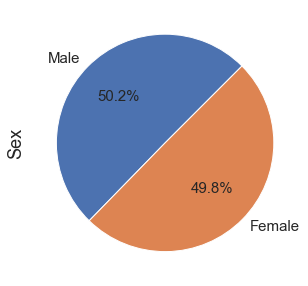

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
fig3, ax3 = plt.subplots(figsize=(6, 3),subplot_kw=dict(aspect="equal"))
genderDf.Sex.value_counts().plot(kind='pie',autopct='%.1f%%',startangle=45,figsize=(5, 5),fontsize=15)

## Quartiles, Outliers and Boxplots

In [13]:
dfWithIQR = masterDf[["Drug Regimen","Timepoint","Tumor Volume (mm3)","Male","Female","Mouse ID"]]\
                .groupby(["Drug Regimen","Timepoint"]).agg(
                                               Q25=("Tumor Volume (mm3)",lambda x: x.quantile(0.25)),\
                                               Q75=("Tumor Volume (mm3)",lambda x: x.quantile(0.75)),\
                                               IQR_25to75 = ("Tumor Volume (mm3)",lambda x: (x.quantile(0.75)-x.quantile(0.25))))\
                                               .reset_index("Timepoint").reset_index("Drug Regimen")


dfWithIQR["lowerLim"] = dfWithIQR["Q25"]-1.5*dfWithIQR["IQR_25to75"];
dfWithIQR["upperLim"] = dfWithIQR["Q75"]+1.5*dfWithIQR["IQR_25to75"];

dfWithOutlierFlag = pd.merge(masterDf,dfWithIQR,how='left', left_on=["Drug Regimen","Timepoint"], right_on = ["Drug Regimen","Timepoint"])

# df[‘c’] = np.where(df.a <df.b, True, False)
#  or use np.select
conditions=[dfWithOutlierFlag["Tumor Volume (mm3)"] < dfWithOutlierFlag["lowerLim"], dfWithOutlierFlag["Tumor Volume (mm3)"] > dfWithOutlierFlag["upperLim"]] 
values=[True, True]
dfWithOutlierFlag["isOutlier"]=np.select(conditions,values)

dfWithOutlierFlag.head(10)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Male,Female,Q25,Q75,IQR_25to75,lowerLim,upperLim,isOutlier
0,k403,Ramicane,Male,21,16,0,45.000000,0,1,0,45.000000,45.000000,0.000000,45.000000,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0,1,0,42.998876,45.625802,2.626926,39.058488,49.566191,1
2,k403,Ramicane,Male,21,16,10,35.014271,1,1,0,40.663625,45.315612,4.651986,33.685646,52.293591,0
3,k403,Ramicane,Male,21,16,15,34.223992,1,1,0,39.394091,44.414444,5.020353,31.863561,51.944974,0
4,k403,Ramicane,Male,21,16,20,32.997729,1,1,0,37.184442,42.647326,5.462884,28.990117,50.841652,0
5,k403,Ramicane,Male,21,16,25,33.464577,1,1,0,36.986348,41.886309,4.899961,29.636406,49.236251,0
6,k403,Ramicane,Male,21,16,30,31.099498,1,1,0,35.213303,41.727310,6.514008,25.442291,51.498322,0
7,k403,Ramicane,Male,21,16,35,26.546993,1,1,0,35.152166,39.717236,4.565070,28.304562,46.564840,1
8,k403,Ramicane,Male,21,16,40,24.365505,1,1,0,33.724867,40.304706,6.579839,23.855109,50.174464,0
9,k403,Ramicane,Male,21,16,45,22.050126,1,1,0,30.981175,38.508305,7.527130,19.690480,49.799000,0


In [14]:
# Remove outlier
dfWithoutlOutlier = dfWithOutlierFlag.loc[dfWithOutlierFlag["isOutlier"]==False]
print(f"{dfWithoutlOutlier.shape}")
dfWithoutlOutlier.head(10)
# 5 outliers are removed

(1863, 16)


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Male,Female,Q25,Q75,IQR_25to75,lowerLim,upperLim,isOutlier
0,k403,Ramicane,Male,21,16,0,45.000000,0,1,0,45.000000,45.000000,0.000000,45.000000,45.000000,0
2,k403,Ramicane,Male,21,16,10,35.014271,1,1,0,40.663625,45.315612,4.651986,33.685646,52.293591,0
3,k403,Ramicane,Male,21,16,15,34.223992,1,1,0,39.394091,44.414444,5.020353,31.863561,51.944974,0
4,k403,Ramicane,Male,21,16,20,32.997729,1,1,0,37.184442,42.647326,5.462884,28.990117,50.841652,0
5,k403,Ramicane,Male,21,16,25,33.464577,1,1,0,36.986348,41.886309,4.899961,29.636406,49.236251,0
6,k403,Ramicane,Male,21,16,30,31.099498,1,1,0,35.213303,41.727310,6.514008,25.442291,51.498322,0
8,k403,Ramicane,Male,21,16,40,24.365505,1,1,0,33.724867,40.304706,6.579839,23.855109,50.174464,0
9,k403,Ramicane,Male,21,16,45,22.050126,1,1,0,30.981175,38.508305,7.527130,19.690480,49.799000,0
10,s185,Capomulin,Female,3,17,0,45.000000,0,0,1,45.000000,45.000000,0.000000,45.000000,45.000000,0
11,s185,Capomulin,Female,3,17,5,43.878496,0,0,1,43.180977,45.760886,2.579909,39.311114,49.630750,0


In [15]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
maxTimepointDf = dfWithoutlOutlier [["Mouse ID","Timepoint"]].groupby(["Mouse ID"])\
                    .agg( Max_Timepoint=("Timepoint","max")).reset_index()
newMasterDf = pd.merge(left=dfWithoutlOutlier ,right=maxTimepointDf, how='outer')

# Interested Regimen
drugList = ["Capomulin", "Ramicane", "Infubinol","Ceftamin"]
filterDf = newMasterDf[newMasterDf["Drug Regimen"].isin(drugList)]
filterDf = filterDf.loc[filterDf["Timepoint"] == filterDf["Max_Timepoint"],:]

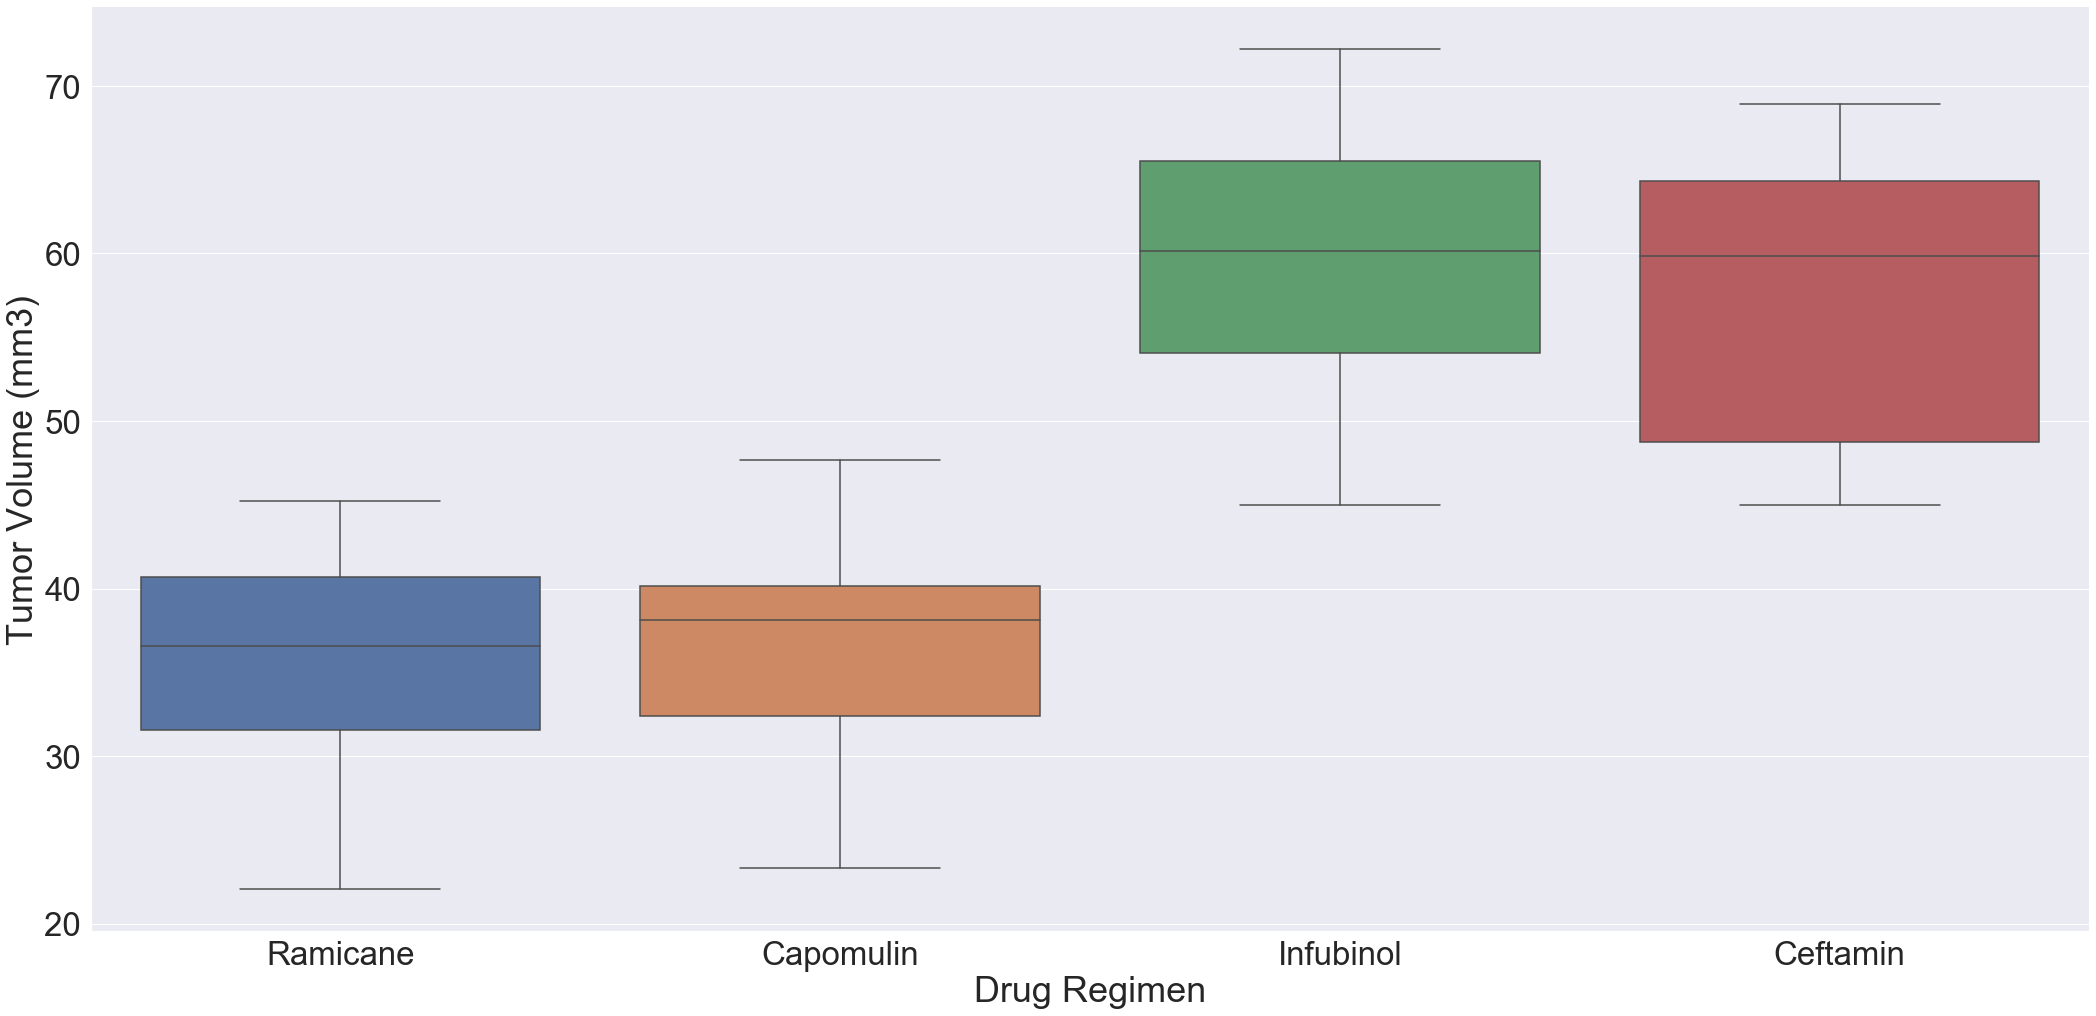

In [16]:
sns.set(font_scale=3)
flierprops = dict(markerfacecolor='r', markersize=15, marker='s')
fig4 = sns.catplot(x = "Drug Regimen",       # x variable name
            y = "Tumor Volume (mm3)",       # y variable name
            data = filterDf,               # dataframe to plot
            kind = "box",
            showfliers=True,
            flierprops=flierprops,
            height=15,
            aspect=2)               
# No outlier!

## Line and Scatter Plots

In [17]:
# The ask is Generate a line plot of tumor volume vs. timepoint for a mouse treated with Capomulin
# I don't think fitting a line for 1 mouse for Capomulin tell a story 
# instead, I am going to try line regression using data with outlier removed from above

sumStatsByTimePointWithoutOutlier =dfWithoutlOutlier[["Drug Regimen","Timepoint","Tumor Volume (mm3)","Male","Female","Mouse ID"]]\
                .groupby(["Drug Regimen","Timepoint"]).agg( Mean_Tumor_Volume=("Tumor Volume (mm3)","mean"),\
                                                Median_Tumor_Volume=("Tumor Volume (mm3)","median"),\
                                                Var_Tumor_Volume=("Tumor Volume (mm3)","var"),\
                                                Std_Tumor_Volume=("Tumor Volume (mm3)","std"),\
                                                Sem_Tumor_Volume=("Tumor Volume (mm3)","sem"),\
                                                Number_of_Mice=("Mouse ID", 'nunique'),\
                                                Number_of_Male =("Male",'sum'),\
                                                Number_of_Female=("Female",'sum')).reset_index("Timepoint").reset_index("Drug Regimen")
sumStatsByTimePointWithoutOutlier.head()

,Drug Regimen,Timepoint,Mean_Tumor_Volume,Median_Tumor_Volume,Var_Tumor_Volume,Std_Tumor_Volume,Sem_Tumor_Volume,Number_of_Mice,Number_of_Male,Number_of_Female
0,Capomulin,0,45.000000,45.000000,0.000000,0.000000,0.000000,25,12,13
1,Capomulin,5,44.724068,45.622381,2.743492,1.656349,0.345373,23,10,13
2,Capomulin,10,43.084291,43.421014,12.344133,3.513422,0.702684,25,12,13
3,Capomulin,15,42.064317,42.798160,16.878693,4.108369,0.838617,24,11,13
4,Capomulin,20,40.716325,40.716428,19.035028,4.362915,0.909731,23,10,13


Text(0.5, 1.0, 'Mean tumor volume vs. timepoint for all mice treated with Capomulin')

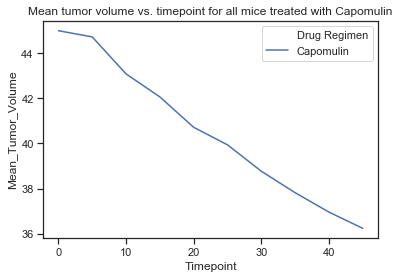

In [18]:
sns.set(font_scale=10)
sns.set(style="ticks")
fig5 = sns.lineplot(x = "Timepoint",       # x variable name
            y = "Mean_Tumor_Volume",       # y variable name
            data = sumStatsByTimePointWithoutOutlier[sumStatsByTimePointWithoutOutlier["Drug Regimen"]=="Capomulin"],     # dataframe to plot
            hue = "Drug Regimen") 
plt.title("Mean tumor volume vs. timepoint for all mice treated with Capomulin")

In [19]:
weightStatsWithoutOutlierAgg =dfWithoutlOutlier[["Drug Regimen","Timepoint","Tumor Volume (mm3)","Male","Female","Mouse ID","Weight (g)"]]\
                .groupby(["Drug Regimen","Weight (g)"]).agg( Mean_Tumor_Volume=("Tumor Volume (mm3)","mean"),\
                                                Median_Tumor_Volume=("Tumor Volume (mm3)","median"),\
                                                Var_Tumor_Volume=("Tumor Volume (mm3)","var"),\
                                                Std_Tumor_Volume=("Tumor Volume (mm3)","std"),\
                                                Sem_Tumor_Volume=("Tumor Volume (mm3)","sem"),\
                                                Number_of_Mice=("Mouse ID", 'nunique'))\
                                               .reset_index("Weight (g)").reset_index("Drug Regimen")
weightStatsWithoutOutlierAgg.head(10)

,Drug Regimen,Weight (g),Mean_Tumor_Volume,Median_Tumor_Volume,Var_Tumor_Volume,Std_Tumor_Volume,Sem_Tumor_Volume,Number_of_Mice
0,Capomulin,15,36.182040,36.341478,39.519766,6.286475,1.987958,1
1,Capomulin,17,37.189408,35.996961,33.603172,5.796824,0.724603,7
2,Capomulin,19,41.182391,42.270497,18.452199,4.295602,0.784266,3
3,Capomulin,20,39.141053,37.645312,15.944893,3.993106,1.262731,1
4,Capomulin,21,42.088700,41.508552,9.381234,3.062880,0.442089,5
5,Capomulin,22,43.288490,44.122116,7.006014,2.646888,0.591862,2
6,Capomulin,23,43.529184,43.629865,5.915701,2.432221,0.518551,3
7,Capomulin,24,44.805810,44.798109,2.892107,1.700620,0.537783,1
8,Capomulin,25,44.062109,45.000000,6.005154,2.450542,0.654935,2
9,Ceftamin,25,51.035238,48.927716,37.853555,6.152524,1.311723,4


## Correlation and Regression

Text(0.5, 1, 'Mouse weight versus average tumor volume for the Capomulin regimen')

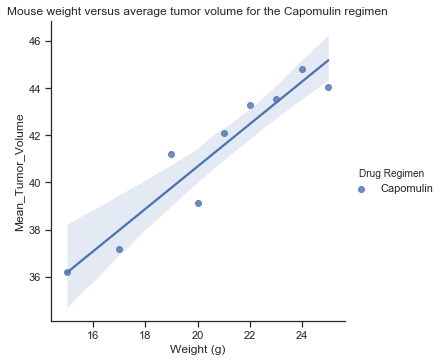

In [20]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
#  at each timepoint for Capomulin
sns.set(font_scale=10)
sns.set(style="ticks")
fig6 = sns.lmplot(x = "Weight (g)",       # x variable name
            y = "Mean_Tumor_Volume",       # y variable name
            data = weightStatsWithoutOutlierAgg.loc[weightStatsWithoutOutlierAgg["Drug Regimen"]=="Capomulin"],     # dataframe to plot
            hue = "Drug Regimen",
            height=5,
            aspect=1)  
plt.title("Mouse weight versus average tumor volume for the Capomulin regimen")

In [21]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen. 
# Calculate the correlation coefficient and linear regression model 
# Note: this means mouse weight goes on the x-axis, with average tumor volume on the y-axis. 

capomulinDf = weightStatsWithoutOutlierAgg.loc[weightStatsWithoutOutlierAgg["Drug Regimen"] == "Capomulin"]
linearSlope, linearInt, linearR, linearP, linearSem = st.linregress(capomulinDf["Weight (g)"], capomulinDf["Mean_Tumor_Volume"])
print(f"Correlation Coefficient is {linearR}")

Correlation Coefficient is 0.9507414656737158


## Other Plots

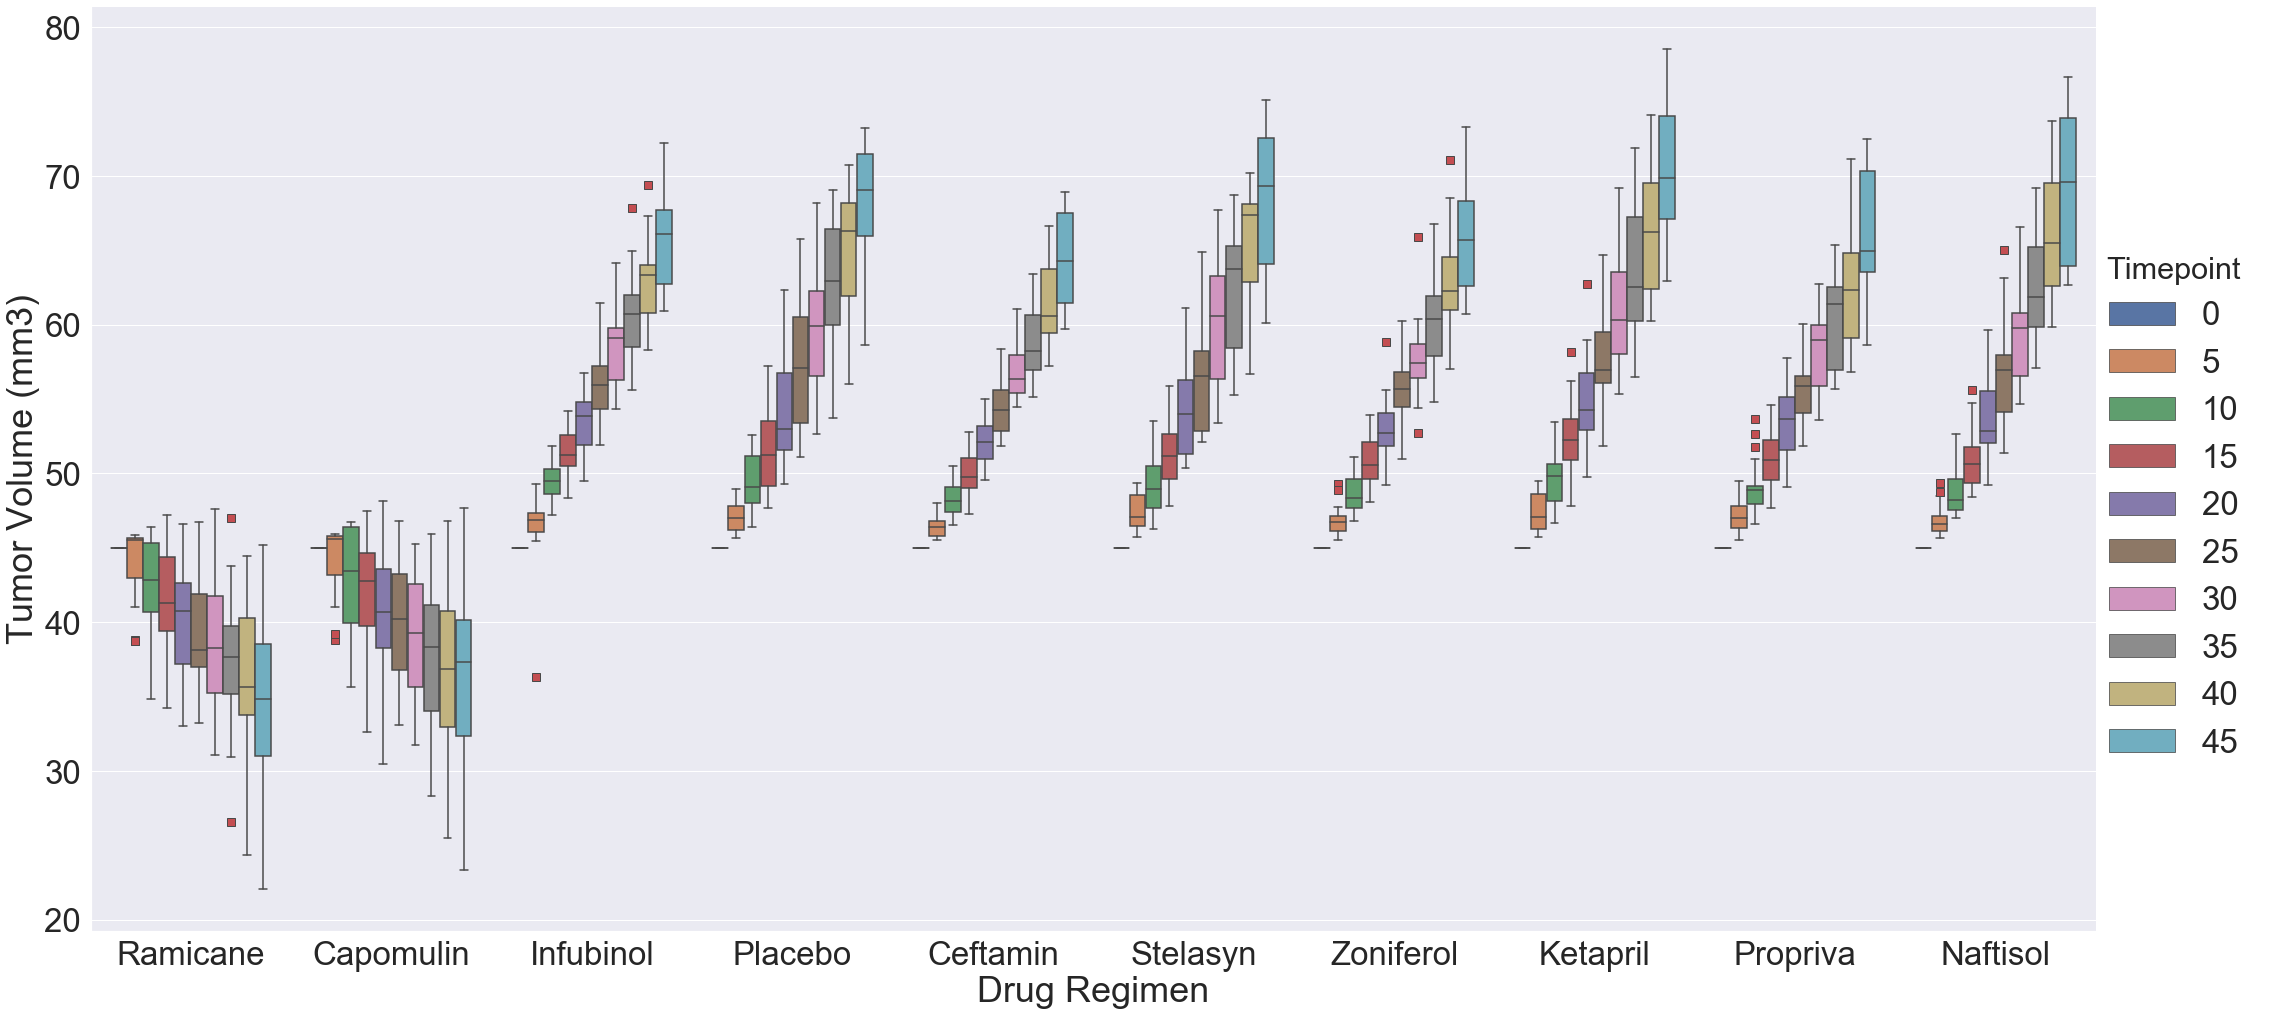

In [22]:
# Use seaborn
# Plot total volume throughout the treatment for each drug regimen
# red quares are outliers
sns.set(font_scale=3)
flierprops = dict(markerfacecolor='r', markersize=8, marker='s')
fig1b = sns.catplot(x = "Drug Regimen",       # x variable name
            y = "Tumor Volume (mm3)",       # y variable name
            data = masterDf,     # dataframe to plot
            hue = "Timepoint",
            kind = "box",
            flierprops=flierprops,
            height=15,
            aspect=2)               # size
#  Based on this box plot: Capomulin and Ramicane are most effective in reducing the tumor size

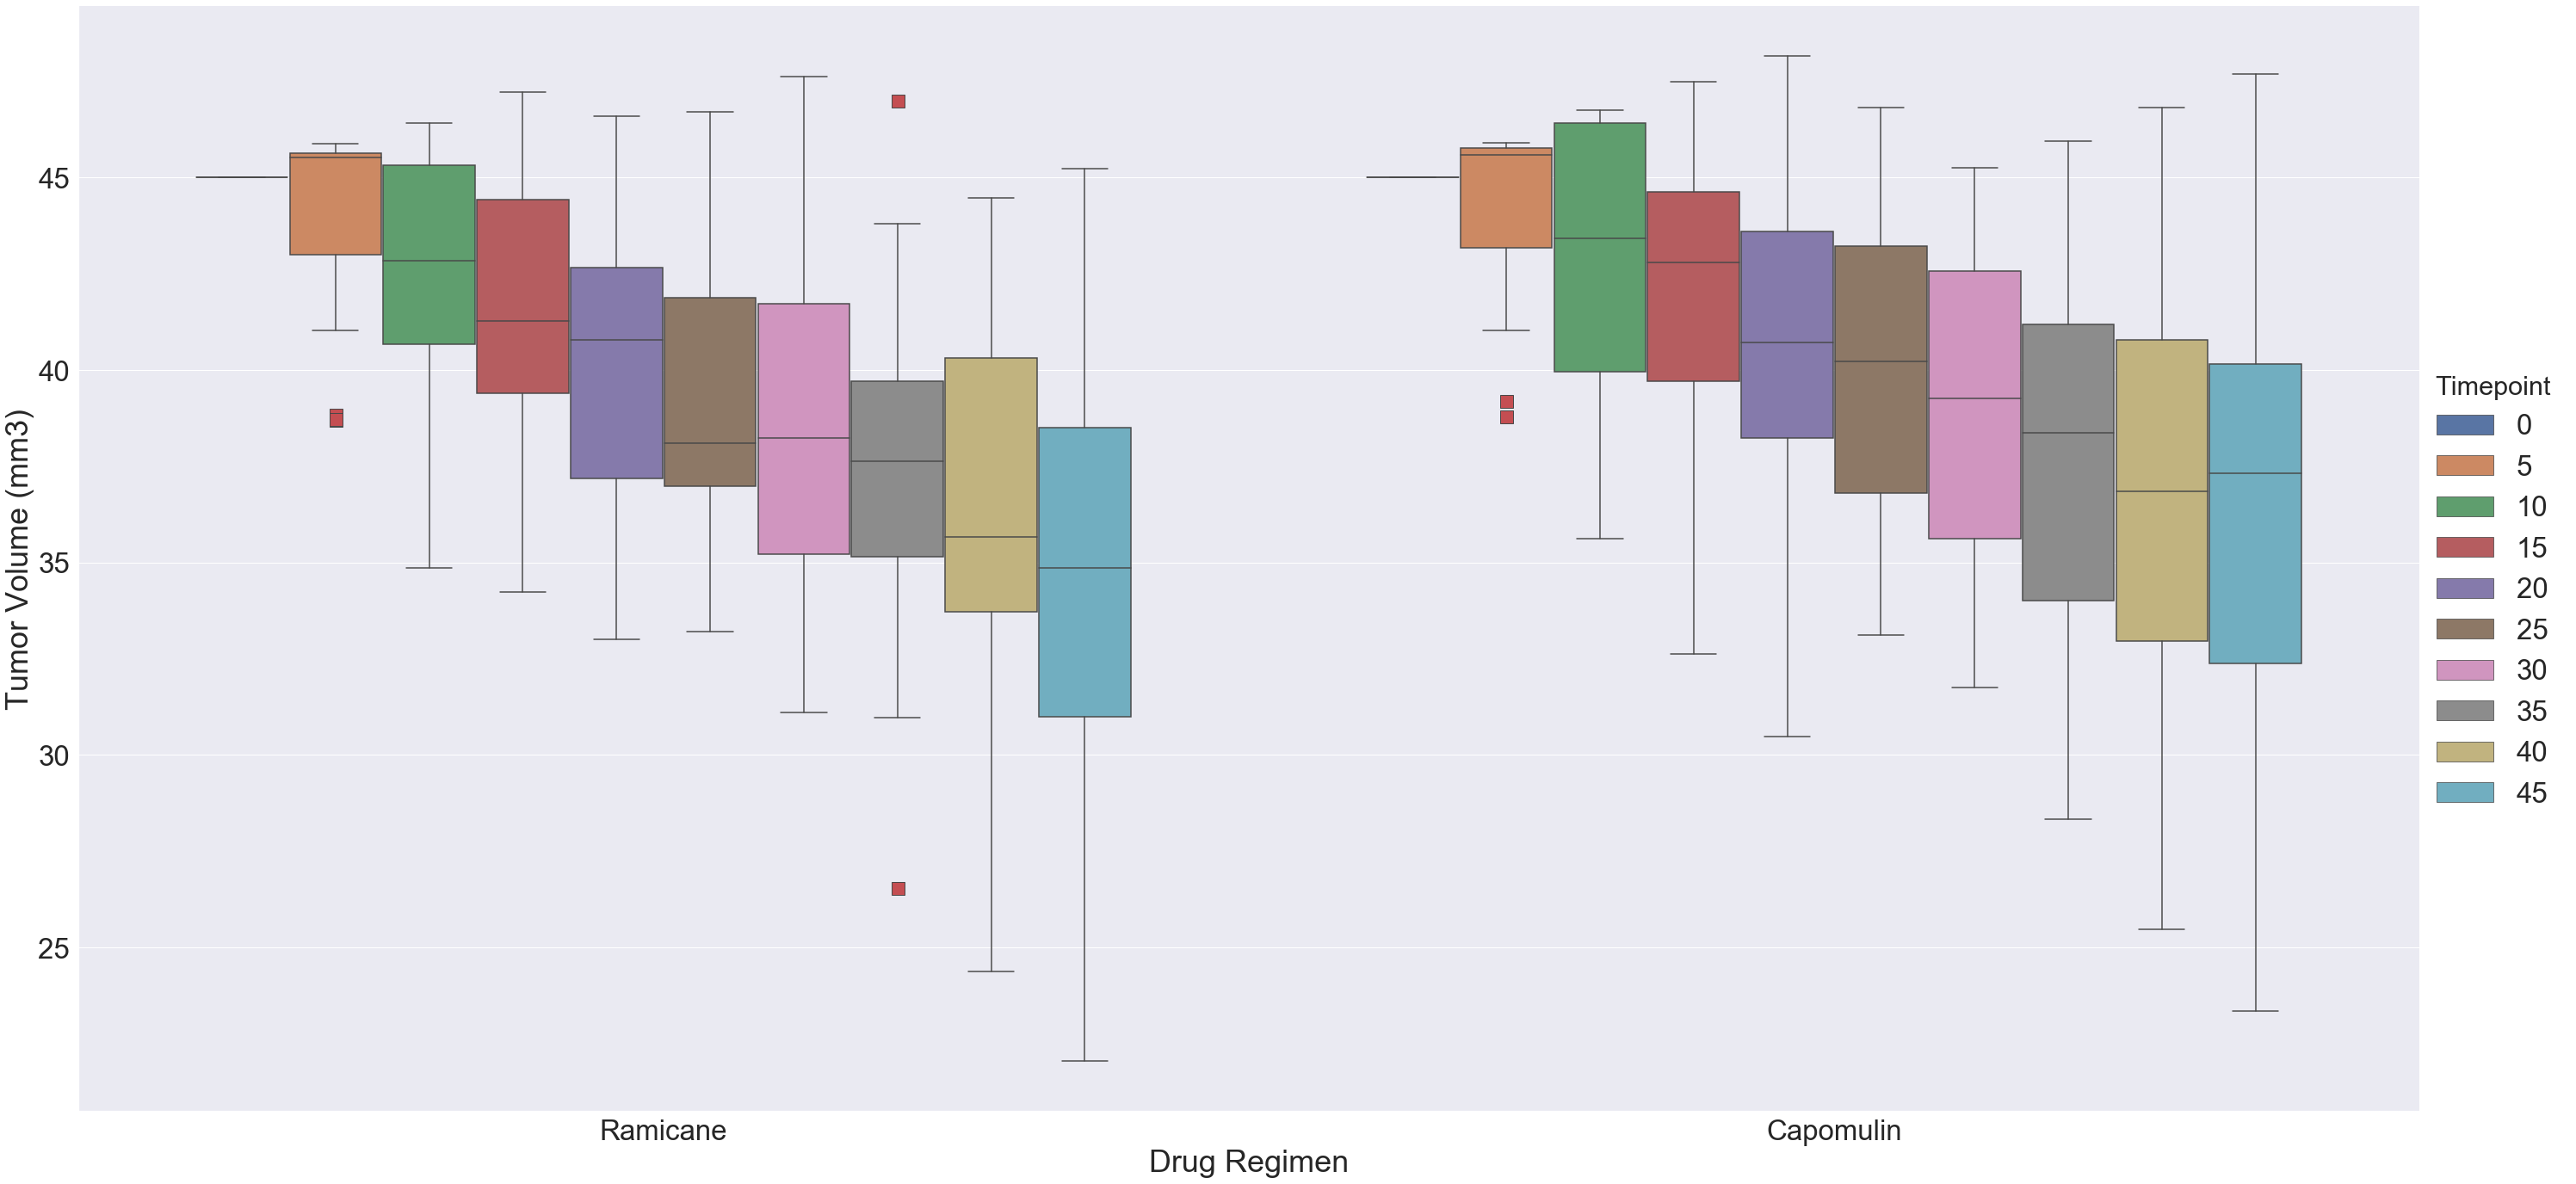

In [23]:
# Use seaborn
# Plot total volume throughout the treatment for Capomulin and "Ramicane"
# Zoom in version of the above plot
# red diamonds are outlier
sns.set(font_scale=3)
flierprops = dict(markerfacecolor='r', markersize=15, marker='s')
fig1c = sns.catplot(x = "Drug Regimen",       # x variable name
            y = "Tumor Volume (mm3)",       # y variable name
            data = masterDf[masterDf["Drug Regimen"].isin(["Capomulin", "Ramicane"])],     # dataframe to plot
            hue = "Timepoint",
            kind = "box",
            showfliers=True,
            flierprops=flierprops,
            height=20,
            aspect=2)           

In [24]:
# get max timepoint for each mouse
maxTimepointDf = masterDf[["Drug Regimen","Mouse ID","Timepoint"]].groupby(["Drug Regimen","Mouse ID"])\
                    .agg( Max_Timepoint=("Timepoint","max")).reset_index()
newMasterDf = pd.merge(left=masterDf,right=maxTimepointDf, how='outer')

# check to see if join properly
print(f"{newMasterDf.shape}")

# Interested Regimens
drugList = ["Capomulin", "Ramicane", "Infubinol","Ceftamin"]
filterDf = newMasterDf[newMasterDf["Drug Regimen"].isin(drugList)]
filterDf = filterDf.loc[filterDf["Timepoint"] == filterDf["Max_Timepoint"],:]
maxTimepointDf.head(10)

(1888, 11)


,Drug Regimen,Mouse ID,Max_Timepoint
0,Capomulin,b128,45
1,Capomulin,b742,45
2,Capomulin,f966,20
3,Capomulin,g288,45
4,Capomulin,g316,45
5,Capomulin,i557,45
6,Capomulin,i738,45
7,Capomulin,j119,45
8,Capomulin,j246,35
9,Capomulin,l509,45


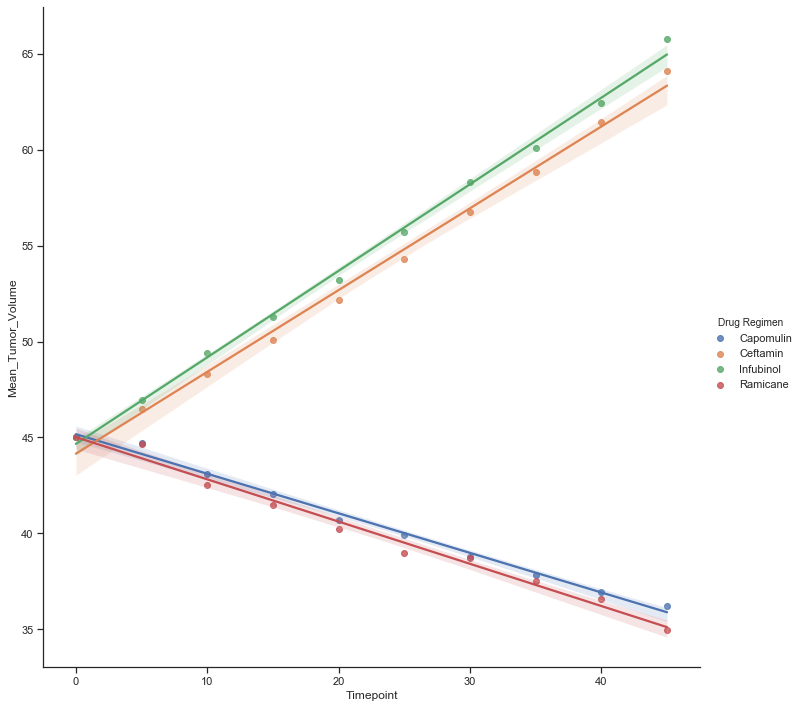

In [25]:
drugList = ["Capomulin", "Ramicane", "Infubinol","Ceftamin"]
sns.set(font_scale=10)
sns.set(style="ticks")
fig5 = sns.lmplot(x = "Timepoint",       # x variable name
            y = "Mean_Tumor_Volume",       # y variable name
            data = sumStatsByTimePointWithoutOutlier[sumStatsByTimePointWithoutOutlier["Drug Regimen"].isin(drugList)],     # dataframe to plot
            hue = "Drug Regimen",
            height=10,
            aspect=1)    

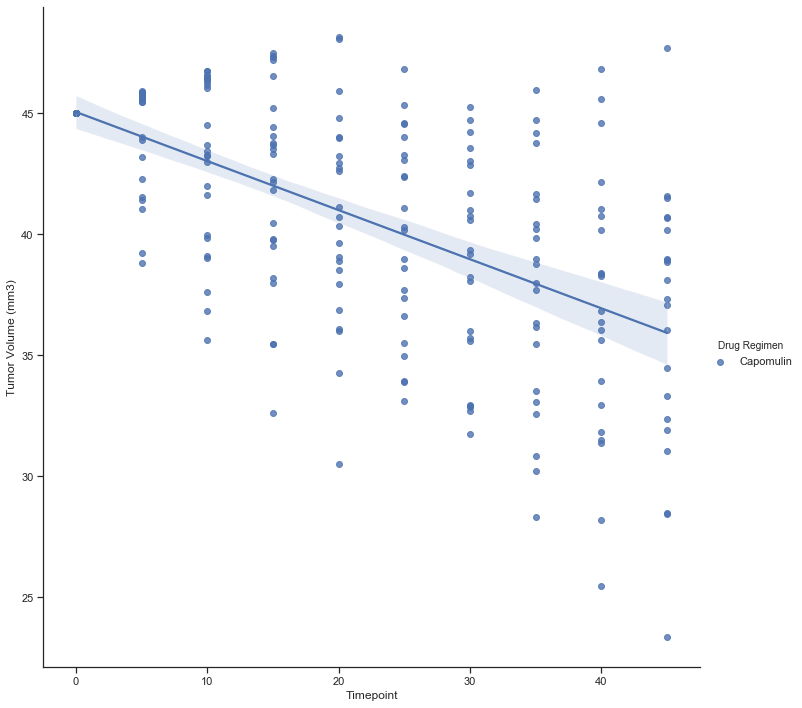

In [26]:
# scatter plot with regression fit across all mice
sns.set(font_scale=10)
sns.set(style="ticks")
fig6 = sns.lmplot(x = "Timepoint",       # x variable name
            y = "Tumor Volume (mm3)",       # y variable name
            data = masterDf[masterDf["Drug Regimen"]== "Capomulin"],     # dataframe to plot
            hue = "Drug Regimen",
            height=10,
            aspect=1)  

In [27]:
# Weight stats
weightStatsWithoutOutlier =dfWithoutlOutlier[["Drug Regimen","Timepoint","Tumor Volume (mm3)","Male","Female","Mouse ID","Weight (g)"]]\
                .groupby(["Drug Regimen","Timepoint","Weight (g)"]).agg( Mean_Tumor_Volume=("Tumor Volume (mm3)","mean"),\
                                                Median_Tumor_Volume=("Tumor Volume (mm3)","median"),\
                                                Var_Tumor_Volume=("Tumor Volume (mm3)","var"),\
                                                Std_Tumor_Volume=("Tumor Volume (mm3)","std"),\
                                                Sem_Tumor_Volume=("Tumor Volume (mm3)","sem"),\
                                                Number_of_Mice=("Mouse ID", 'nunique'),\
                                                Number_of_Male =("Male",'sum'),\
                                                Number_of_Female=("Female",'sum'))\
                                                .reset_index("Weight (g)").reset_index("Timepoint").reset_index("Drug Regimen")
weightStatsWithoutOutlier.head(10)

,Drug Regimen,Timepoint,Weight (g),Mean_Tumor_Volume,Median_Tumor_Volume,Var_Tumor_Volume,Std_Tumor_Volume,Sem_Tumor_Volume,Number_of_Mice,Number_of_Male,Number_of_Female
0,Capomulin,0,15,45.000000,45.000000,NaN,NaN,NaN,1,0,1
1,Capomulin,0,17,45.000000,45.000000,0.0,0.0,0.0,7,4,3
2,Capomulin,0,19,45.000000,45.000000,0.0,0.0,0.0,3,2,1
3,Capomulin,0,20,45.000000,45.000000,NaN,NaN,NaN,1,0,1
4,Capomulin,0,21,45.000000,45.000000,0.0,0.0,0.0,5,3,2
5,Capomulin,0,22,45.000000,45.000000,0.0,0.0,0.0,2,0,2
6,Capomulin,0,23,45.000000,45.000000,0.0,0.0,0.0,3,1,2
7,Capomulin,0,24,45.000000,45.000000,NaN,NaN,NaN,1,0,1
8,Capomulin,0,25,45.000000,45.000000,0.0,0.0,0.0,2,2,0
9,Capomulin,5,15,45.473753,45.473753,NaN,NaN,NaN,1,0,1


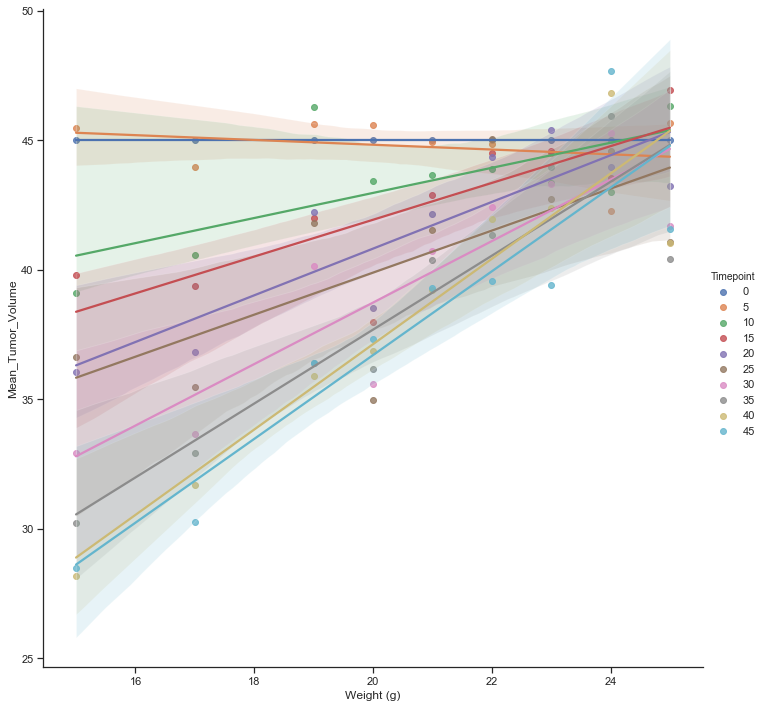

In [28]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
#  at each timepoint for Capomulin
sns.set(font_scale=10)
sns.set(style="ticks")
fig6 = sns.lmplot(x = "Weight (g)",       # x variable name
            y = "Mean_Tumor_Volume",       # y variable name
            data = weightStatsWithoutOutlier.loc[weightStatsWithoutOutlier["Drug Regimen"]=="Capomulin"],     # dataframe to plot
            hue = "Timepoint",
            height=10,
            aspect=1)  

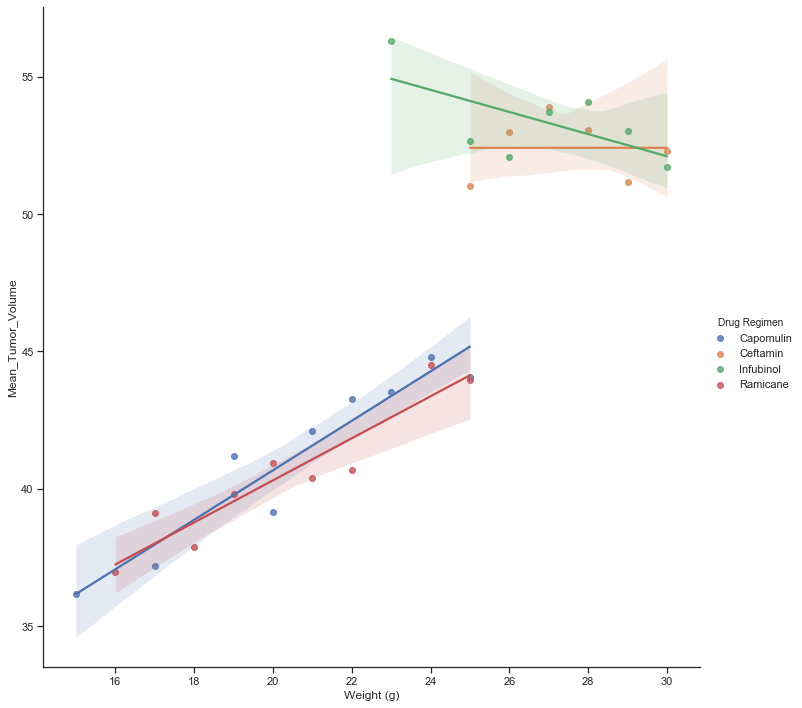

In [29]:
sns.set(font_scale=10)
sns.set(style="ticks")
fig7 = sns.lmplot(x = "Weight (g)",       # x variable name
            y = "Mean_Tumor_Volume",       # y variable name
            data = weightStatsWithoutOutlierAgg.loc[weightStatsWithoutOutlierAgg["Drug Regimen"].isin(drugList)],     # dataframe to plot
            hue = "Drug Regimen",
            height=10,
            aspect=1)  